In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('cuda_ad_rgb')

from mimt import *

In [32]:
scene_dict = mi.cornell_box()

del scene_dict['large-box']
del scene_dict['small-box']

scene_dict['shape'] = {
    'type': 'sphere',
    'radius': 0.5,
    'bsdf': {'type': 'ref', 'id': 'white'}
}

integrator_names = ['prb', 'prb_threepoint', 'ad_threepoint', 'ad']

spp = 128

results = []
for integrator_name in integrator_names:
    # Load the different integrators
    scene_dict_ = scene_dict.copy()
    scene_dict_['integrator'] = {
        'type': integrator_name,
        'max_depth': 8
    }

    scene  = mi.load_dict(scene_dict_)
    params = mi.traverse(scene)
    to_world_original = dr.copy(params['shape.to_world'])

    # Primal image + forward derivatives
    offset = mi.Float(0)
    dr.enable_grad(offset)
    params['shape.to_world'] = to_world_original.translate(mi.Point3f(0, offset, 0))
    params.update()

    #dr.set_grad(offset, 1)
    #dr.enqueue(dr.ADMode.Forward, offset)
    #dr.traverse(dr.ADMode.Forward, dr.ADFlag.ClearEdges)
    img = mi.render(scene, params=params, spp=spp)

    #dr.enqueue(dr.ADMode.Forward, params['shape.to_world'])
    #dr.traverse(dr.ADMode.Forward)
    dr.forward_from(offset)
    img_grad = dr.grad(img)

    # Finite differences
    eps = 1e-3
    params['shape.to_world'] = to_world_original.translate(mi.Point3f(0, eps, 0))
    params.update()
    img_fwd = mi.render(scene, params=params, spp=spp)

    params['shape.to_world'] = to_world_original.translate(mi.Point3f(0, -eps, 0))
    params.update()
    img_bwd = mi.render(scene, params=params, spp=spp)

    img_grad_fd = (img_fwd - img_bwd) / (2*eps)

    dr.eval(img, img_grad, img_grad_fd)

    del params, scene

    results += [(integrator_name, img, img_grad, img_grad_fd)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.5175002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-109.84528..2.0579357].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-211.68585..6.6695056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.517505].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-243.7174..5.217655].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-211.66743..6.669712].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-18.304367..1.171074].
Clip

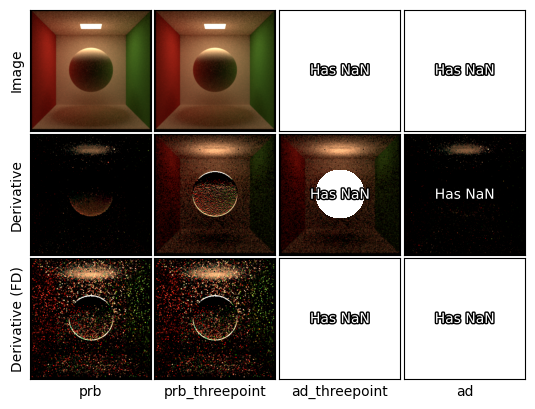

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

fig = plt.figure()

gs = fig.add_gridspec(3, len(integrator_names), wspace=0.025, hspace=0.025)

#fig, axs = plt.subplots(3, len(integrator_names))

def maybe_label_nan(ax, img):
    if dr.any(~dr.isfinite(img)):
        h, w, _ = img.shape
        ax.annotate("Has NaN", (w//2, h//2), va='center', ha='center', 
                    color='white', path_effects=[pe.withStroke(linewidth=2, foreground="black")])

for integrator_idx, result in enumerate(results):
    name, img, img_grad, img_grad_fd = result

    ax = fig.add_subplot(gs[0, integrator_idx])
    disable_ticks(ax)
    ax.imshow(mi.Bitmap(img).convert(srgb_gamma=True))
    maybe_label_nan(ax, img)
    if integrator_idx == 0:
        ax.set_ylabel("Image")

    ax = fig.add_subplot(gs[1, integrator_idx])
    disable_ticks(ax)
    ax.imshow(mi.Bitmap(img_grad).convert(srgb_gamma=True))
    maybe_label_nan(ax, img)
    if integrator_idx == 0:
        ax.set_ylabel("Derivative")

    ax = fig.add_subplot(gs[2, integrator_idx])
    disable_ticks(ax)
    ax.imshow(mi.Bitmap(img_grad_fd).convert(srgb_gamma=True))
    ax.set_xlabel(name)
    maybe_label_nan(ax, img)
    if integrator_idx == 0:
        ax.set_ylabel("Derivative (FD)")